In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from feature_engine.selection import SelectByShuffling
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [2]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Weather', 'Total Consumers'])
data.keys()

dict_keys(['Weather', 'Total Consumers'])

In [3]:
df_weather = data['Weather']
df_tc = data['Total Consumers']
df_weather

,datetime,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2
0,2019-01-01 00:15:00.000,8,4,1030,5,7,76,0,0,0
1,2019-01-01 00:30:00.000,8,4,1030,3,6,76,0,0,0
2,2019-01-01 00:45:00.000,8,4,1030,4,6,78,0,0,0
3,2019-01-01 01:00:00.000,8,4,1030,3,6,78,0,0,0
4,2019-01-01 01:15:00.000,8,4,1030,2,8,78,0,0,0
...,...,...,...,...,...,...,...,...,...,...
35034,NaN,0,0,0,0,0,0,0,0,0
35035,NaN,0,0,0,0,0,0,0,0,0
35036,NaN,0,0,0,0,0,0,0,0,0
35037,NaN,0,0,0,0,0,0,0,0,0


In [4]:
df_weather.isnull().sum()

datetime                  22953
TemperatureC                  0
DewpointC                     0
PressurehPa                   0
WindSpeedKMH                  0
WindSpeedGustKMH              0
Humidity                      0
HourlyPrecipMM                0
dailyrainMM                   0
SolarRadiationWatts_m2        0
dtype: int64

In [5]:
df_energy = df_tc[0]
df_energy

0        2.964
1        2.584
2        3.071
3        2.694
4        2.569
         ...  
35131    1.664
35132    1.659
35133    1.664
35134    1.697
35135    1.673
Name: 0, Length: 35136, dtype: float64

## Plot some data

In [6]:
# Drop NaN values from weather dataset
df_weather.dropna(axis=0, inplace=True)
df_weather.reset_index(drop=True, inplace=True)
df_weather

,datetime,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2
0,2019-01-01 00:15:00.000,8,4,1030,5,7,76,0,0,0
1,2019-01-01 00:30:00.000,8,4,1030,3,6,76,0,0,0
2,2019-01-01 00:45:00.000,8,4,1030,4,6,78,0,0,0
3,2019-01-01 01:00:00.000,8,4,1030,3,6,78,0,0,0
4,2019-01-01 01:15:00.000,8,4,1030,2,8,78,0,0,0
...,...,...,...,...,...,...,...,...,...,...
12081,2019-05-17 23:00:00.000,12,8,1017,11,19,76,0,0,0
12082,2019-05-17 23:15:00.000,12,8,1016,11,17,76,0,0,0
12083,2019-05-17 23:30:00.000,12,8,1016,4,12,76,0,0,0
12084,2019-05-17 23:45:00.000,12,8,1016,3,14,76,0,0,0


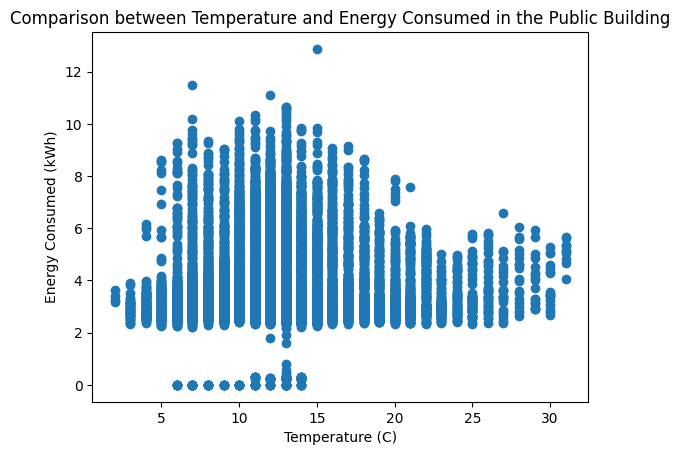

In [7]:
plt.scatter(df_weather['TemperatureC'], df_energy[0:df_weather['TemperatureC'].shape[0]])
plt.xlabel('Temperature (C)') 
plt.ylabel('Energy Consumed (kWh)')
plt.title('Comparison between Temperature and Energy Consumed in the Public Building')
plt.show()

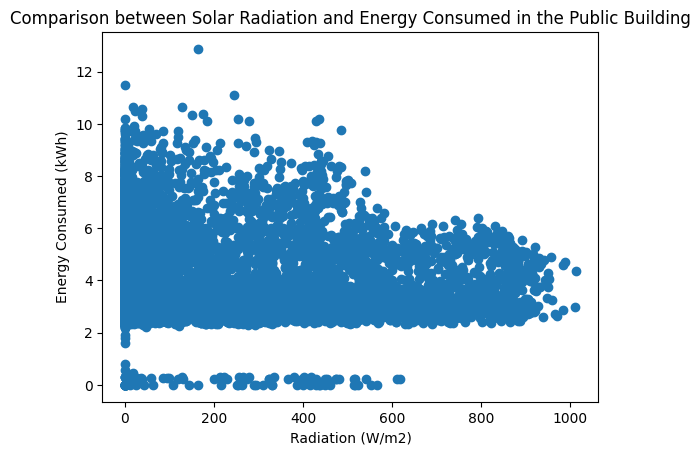

In [8]:
plt.scatter(df_weather['SolarRadiationWatts_m2'], df_energy[0:df_weather['TemperatureC'].shape[0]])
plt.xlabel('Radiation (W/m2)') 
plt.ylabel('Energy Consumed (kWh)')
plt.title('Comparison between Solar Radiation and Energy Consumed in the Public Building')
plt.show()

## Auxiliary functions

In [9]:
def build_model(X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return model, preds


def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    wmape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('RMSE: %.4f' % rmse)
    print('MAE: %.4f' % mae)
    print('WMAPE: %.4f' % wmape)
    print('R2: %.4f' % r2)

### First Model (all weather features)

In [10]:
# Remove Datetime because XGB doesn't allow categorical variables
df_weather_no_date = df_weather.drop('datetime', axis=1, inplace=False)
df_weather_no_date

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2
0,8,4,1030,5,7,76,0,0,0
1,8,4,1030,3,6,76,0,0,0
2,8,4,1030,4,6,78,0,0,0
3,8,4,1030,3,6,78,0,0,0
4,8,4,1030,2,8,78,0,0,0
...,...,...,...,...,...,...,...,...,...
12081,12,8,1017,11,19,76,0,0,0
12082,12,8,1016,11,17,76,0,0,0
12083,12,8,1016,4,12,76,0,0,0
12084,12,8,1016,3,14,76,0,0,0


In [11]:
# Transform energy dataset to be the same size as the weather one
df_energy_new = df_energy[0:df_weather.shape[0]]
X = df_weather_no_date
y = df_energy_new
df_energy_new

0        2.964
1        2.584
2        3.071
3        2.694
4        2.569
         ...  
12081    3.115
12082    2.596
12083    2.903
12084    2.789
12085    2.844
Name: 0, Length: 12086, dtype: float64

### Second Model (all weather features + last 24 hours)
##### Since the data is in intervals of 15 minutes, it will add 24 * 4 = 96 new features

In [12]:
y2 = df_energy_new
X2 = df_weather_no_date
features_96 = pd.DataFrame()
for i in range(1, 97):
    features_96[f'Energy_{i}'] = y2.shift(i)

features_96

,Energy_1,Energy_2,Energy_3,Energy_4,Energy_5,Energy_6,Energy_7,Energy_8,Energy_9,Energy_10,...,Energy_87,Energy_88,Energy_89,Energy_90,Energy_91,Energy_92,Energy_93,Energy_94,Energy_95,Energy_96
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.584,2.964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.071,2.584,2.964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.694,3.071,2.584,2.964,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,3.106,2.932,3.233,2.907,3.387,3.942,4.088,4.800,4.383,4.830,...,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574,3.053,3.048
12082,3.115,3.106,2.932,3.233,2.907,3.387,3.942,4.088,4.800,4.383,...,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574,3.053
12083,2.596,3.115,3.106,2.932,3.233,2.907,3.387,3.942,4.088,4.800,...,2.550,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574
12084,2.903,2.596,3.115,3.106,2.932,3.233,2.907,3.387,3.942,4.088,...,3.253,2.550,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293


In [13]:
# Merge with new 96 features and the target
X_2nd_model = pd.concat([X2, features_96, y2.rename('Energy_out')], axis=1)
X_2nd_model

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Energy_1,...,Energy_88,Energy_89,Energy_90,Energy_91,Energy_92,Energy_93,Energy_94,Energy_95,Energy_96,Energy_out
0,8,4,1030,5,7,76,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.964
1,8,4,1030,3,6,76,0,0,0,2.964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584
2,8,4,1030,4,6,78,0,0,0,2.584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.071
3,8,4,1030,3,6,78,0,0,0,3.071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.694
4,8,4,1030,2,8,78,0,0,0,2.694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,12,8,1017,11,19,76,0,0,0,3.106,...,2.682,3.021,2.963,2.618,2.738,3.293,2.574,3.053,3.048,3.115
12082,12,8,1016,11,17,76,0,0,0,3.115,...,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574,3.053,2.596
12083,12,8,1016,4,12,76,0,0,0,2.596,...,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574,2.903
12084,12,8,1016,3,14,76,0,0,0,2.903,...,2.550,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.789


In [14]:
# Drop NaN values
X24_merged = X_2nd_model.dropna(axis=0).reset_index(drop=True)
# Separate into X and y
X24 = X24_merged.drop('Energy_out', axis=1, inplace=False)
y24 = X24_merged['Energy_out']
X24

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Energy_1,...,Energy_87,Energy_88,Energy_89,Energy_90,Energy_91,Energy_92,Energy_93,Energy_94,Energy_95,Energy_96
0,6,5,1032,1,3,91,0,0,0,2.528,...,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584,2.964
1,6,5,1032,2,4,91,0,0,0,3.054,...,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584
2,6,5,1032,1,3,91,0,0,0,2.677,...,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071
3,6,5,1032,2,3,92,0,0,0,3.522,...,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694
4,6,5,1032,0,4,92,0,0,0,2.729,...,2.514,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,12,8,1017,11,19,76,0,0,0,3.106,...,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574,3.053,3.048
11986,12,8,1016,11,17,76,0,0,0,3.115,...,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574,3.053
11987,12,8,1016,4,12,76,0,0,0,2.596,...,2.550,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293,2.574
11988,12,8,1016,3,14,76,0,0,0,2.903,...,3.253,2.550,2.814,3.028,2.682,3.021,2.963,2.618,2.738,3.293


### Third Model (all weather features + last 7 days at exact same time)
##### Multiply i by 96 to skip a day

In [15]:
y3 = df_energy_new
X3 = df_weather_no_date
features_7 = pd.DataFrame()
for i in range(1, 8):
    features_7[f'Energy_{i}'] = y3.shift(i * 96)

features_7

,Energy_1,Energy_2,Energy_3,Energy_4,Energy_5,Energy_6,Energy_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12081,3.048,3.602,3.040,3.061,2.871,2.686,2.601
12082,3.053,2.689,3.010,3.766,2.442,2.822,2.700
12083,2.574,3.328,3.033,3.215,2.669,2.872,2.477
12084,3.293,2.636,3.179,2.933,2.963,2.809,2.439


In [16]:
# Merge with new 7 features and target
X_3rd_model = pd.concat([X3, features_7, y3.rename('Energy_out')], axis=1)
X_3rd_model

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Energy_1,Energy_2,Energy_3,Energy_4,Energy_5,Energy_6,Energy_7,Energy_out
0,8,4,1030,5,7,76,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.964
1,8,4,1030,3,6,76,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584
2,8,4,1030,4,6,78,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.071
3,8,4,1030,3,6,78,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.694
4,8,4,1030,2,8,78,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,12,8,1017,11,19,76,0,0,0,3.048,3.602,3.040,3.061,2.871,2.686,2.601,3.115
12082,12,8,1016,11,17,76,0,0,0,3.053,2.689,3.010,3.766,2.442,2.822,2.700,2.596
12083,12,8,1016,4,12,76,0,0,0,2.574,3.328,3.033,3.215,2.669,2.872,2.477,2.903
12084,12,8,1016,3,14,76,0,0,0,3.293,2.636,3.179,2.933,2.963,2.809,2.439,2.789


In [17]:
# Drop NaN values
X7_merged = X_3rd_model.dropna(axis=0).reset_index(drop=True)
# Separate into X and y
X7 = X7_merged.drop('Energy_out', axis=1, inplace=False)
y7 = X7_merged['Energy_out']
X7

,TemperatureC,DewpointC,PressurehPa,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Energy_1,Energy_2,Energy_3,Energy_4,Energy_5,Energy_6,Energy_7
0,10,1,1027,4,10,57,0,0,0,2.615,3.321,3.066,2.351,2.851,3.054,2.964
1,10,1,1027,4,10,57,0,0,0,2.634,2.873,3.152,2.843,3.102,2.677,2.584
2,10,1,1027,4,11,57,0,0,0,3.052,3.407,2.633,2.949,2.546,3.522,3.071
3,10,1,1026,3,7,57,0,0,0,2.893,2.673,2.590,2.605,3.016,2.729,2.694
4,9,1,1026,4,8,58,0,0,0,2.349,2.390,2.330,3.023,3.031,2.368,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11409,12,8,1017,11,19,76,0,0,0,3.048,3.602,3.040,3.061,2.871,2.686,2.601
11410,12,8,1016,11,17,76,0,0,0,3.053,2.689,3.010,3.766,2.442,2.822,2.700
11411,12,8,1016,4,12,76,0,0,0,2.574,3.328,3.033,3.215,2.669,2.872,2.477
11412,12,8,1016,3,14,76,0,0,0,3.293,2.636,3.179,2.933,2.963,2.809,2.439


## Train and Predict Models

In [18]:
# First Model (all weather features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model, preds = build_model(X_train, y_train, X_test)

# Second Model (weather features + last 24 hours)
X24_train, X24_test, y24_train, y24_test = train_test_split(X24, y24, test_size=0.2, random_state=42)
model24, preds24 = build_model(X24_train, y24_train, X24_test)

# Third Model (weather features + last 7 days at the exact same time)
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=0.2, random_state=42)
model7, preds7 = build_model(X7_train, y7_train, X7_test)

## Plot Models and Show Performance Metrics

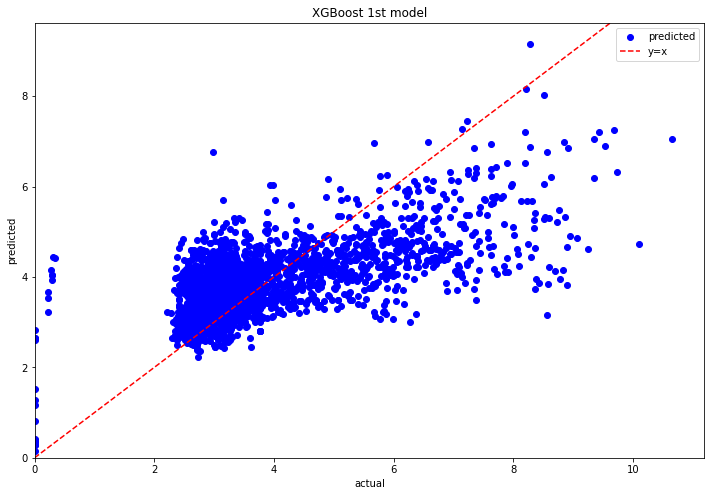

In [19]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 1st model')

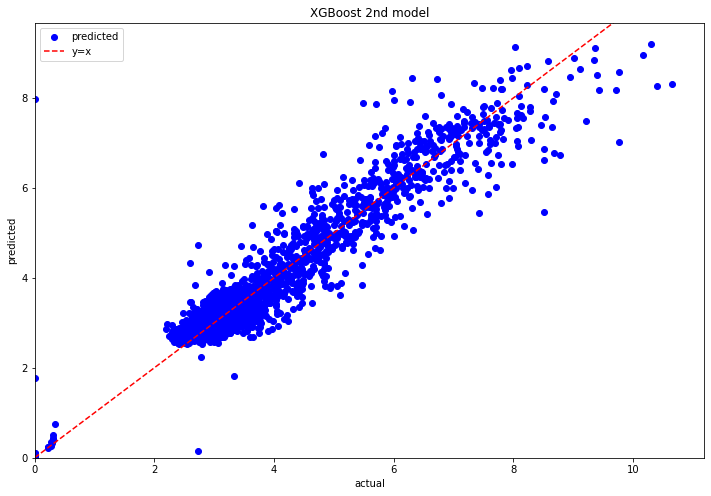

In [20]:
plt.figure(figsize=(12, 8))

plot_results(preds24, y24_test, 'XGBoost 2nd model')

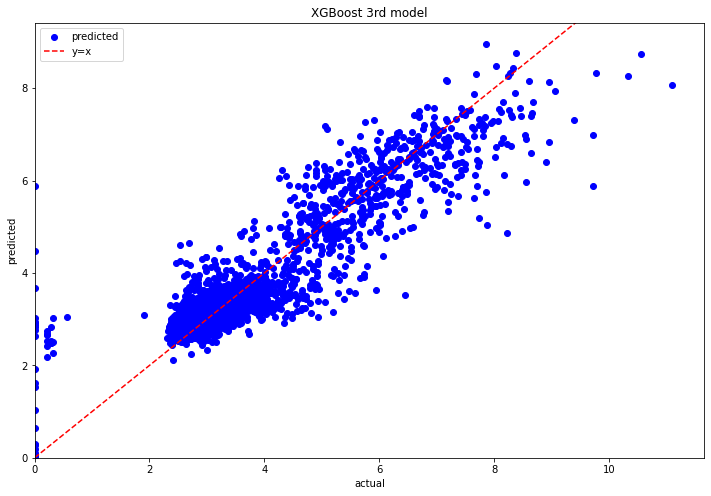

In [21]:
plt.figure(figsize=(12, 8))

plot_results(preds7, y7_test, 'XGBoost 3rd model')

In [22]:
print("First Model")
performance_metrics(preds, y_test.values.reshape(-1))
print()
print("Second Model")
performance_metrics(preds24, y24_test.values.reshape(-1))
print()
print("Third Model")
performance_metrics(preds7, y7_test.values.reshape(-1))

First Model
MSE: 1.2537
RMSE: 1.1197
MAE: 0.8132
WMAPE: 21.3596
R2: 0.4335

Second Model
MSE: 0.2145
RMSE: 0.4631
MAE: 0.2975
WMAPE: 7.7807
R2: 0.9028

Third Model
MSE: 0.4201
RMSE: 0.6481
MAE: 0.4336
WMAPE: 11.2931
R2: 0.8165


## Cross Validation

In [23]:
def cv_validate(classifier, X, y, k):
    scores = cross_validate(classifier, X, y, cv=KFold(n_splits=k, shuffle=True),scoring='r2', return_estimator=True)
    print("R2 score: %0.2f +- %0.2f" % (scores['test_score'].mean(), scores['test_score'].std()))
    return scores

In [24]:
scores = cv_validate(xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42), X_train, y_train, 10)

R2 score: 0.45 +- 0.03


In [25]:
scores24 = cv_validate(xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42), X24_train, y24_train, 10)

R2 score: 0.92 +- 0.01


In [26]:
scores7 = cv_validate(xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42), X7_train, y7_train, 10)

R2 score: 0.81 +- 0.02


In [27]:
scores['test_score'], scores24['test_score'], scores7['test_score']

(array([0.48602664, 0.46667496, 0.49364958, 0.47559567, 0.40308237,
        0.40036282, 0.42074237, 0.46374721, 0.46132555, 0.45918745]),
 array([0.93149979, 0.90506559, 0.90678267, 0.92385382, 0.92074078,
        0.88876074, 0.92343673, 0.92503548, 0.92693316, 0.91906676]),
 array([0.7842081 , 0.82145445, 0.81356156, 0.79947971, 0.79558401,
        0.81041908, 0.84669343, 0.78799994, 0.81908744, 0.80161989]))

## Feature Importance

In [28]:
model.feature_importances_

array([0.12562646, 0.12005223, 0.14263792, 0.03783444, 0.09688658,
       0.11704353, 0.03941116, 0.201799  , 0.1187087 ], dtype=float32)

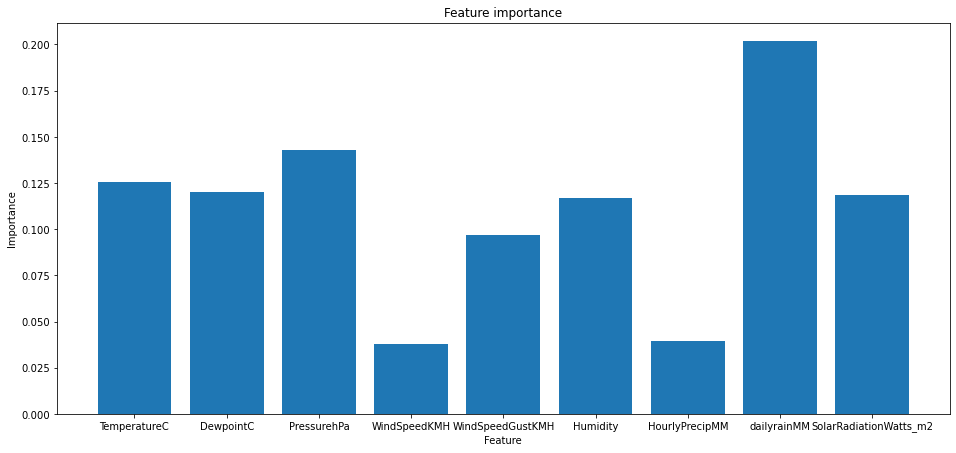

In [29]:
time_importance = model.feature_importances_

plt.figure(figsize=(16, 7.2))
plt.bar(X.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

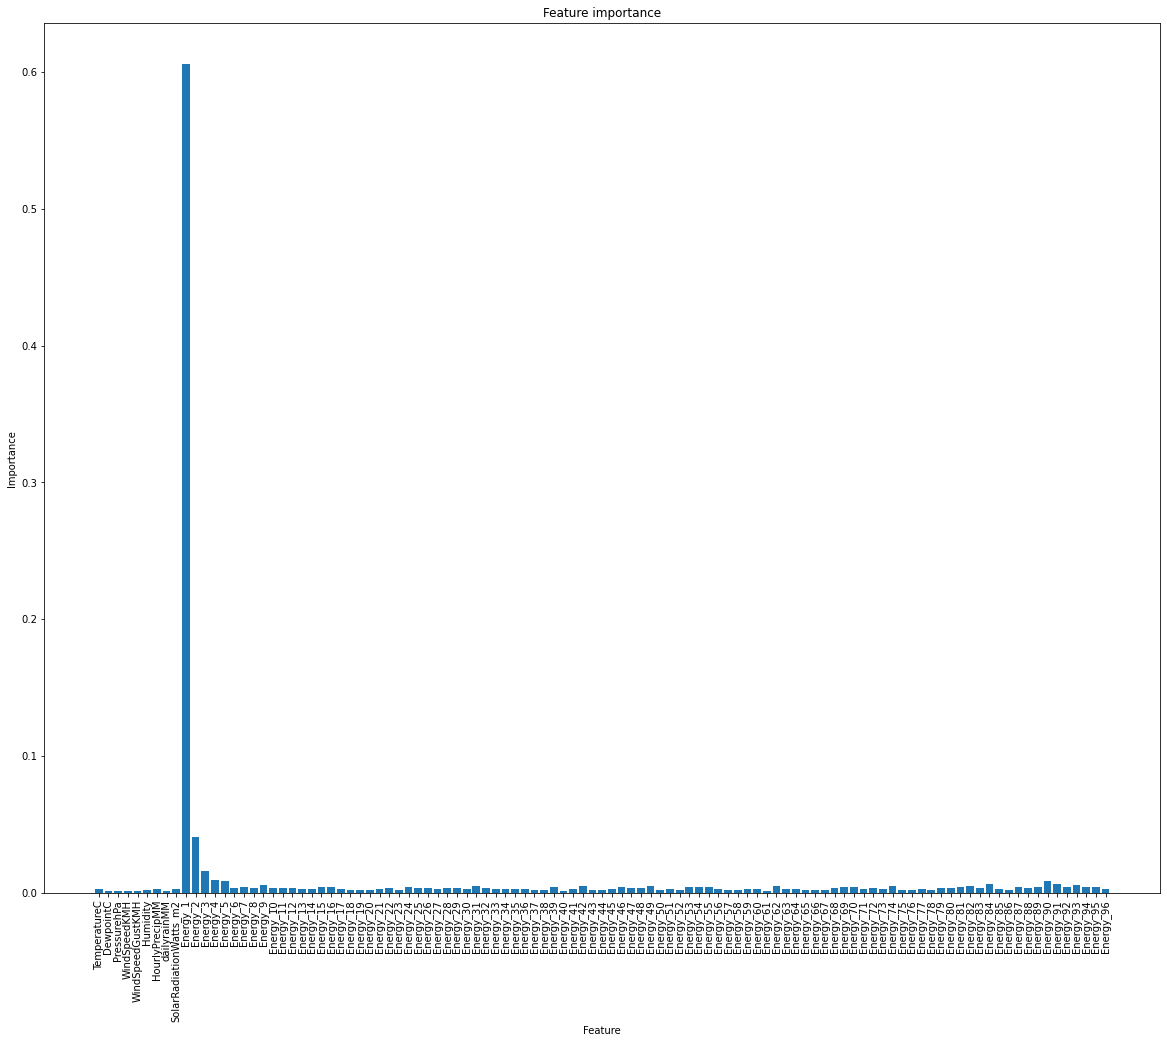

In [30]:
time_importance = model24.feature_importances_

plt.figure(figsize=(20, 16))
plt.bar(X24.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

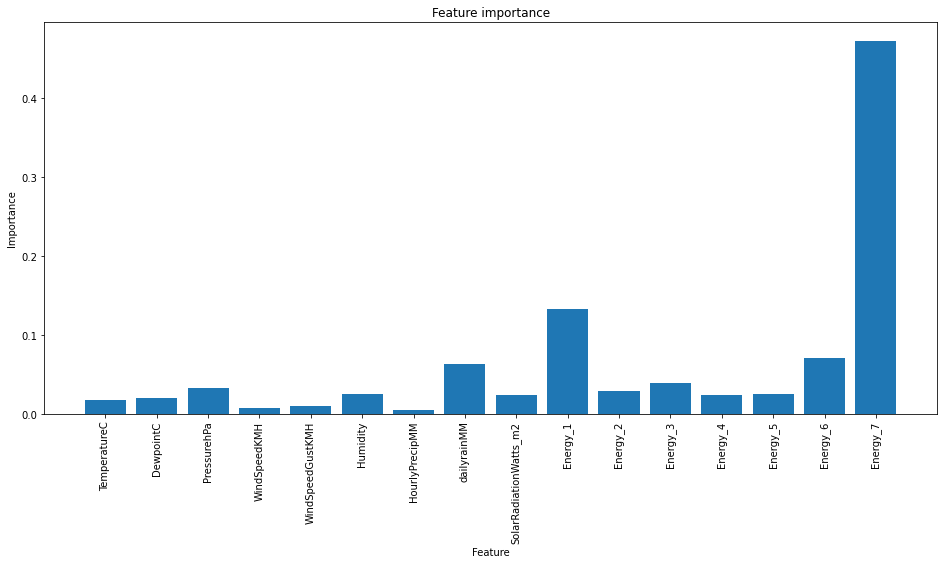

In [31]:
time_importance = model7.feature_importances_

plt.figure(figsize=(16, 7.2))
plt.bar(X7.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## Feature Shuffling
#### Only the second model is represented

In [32]:
sel = SelectByShuffling(
    estimator=xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42), # the ML model
    scoring='r2', # the metric to evaluate
    threshold=0, # the maximum performance drop allowed to select the feature
    cv=10, # cross validation
    random_state=42 # seed
)

sel.fit(X24_train, y24_train)

SelectByShuffling(cv=10,
                  estimator=XGBRegressor(base_score=None, booster=None,
                                         colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None,
                                         enable_categorical=False, gamma=None,
                                         gpu_id=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=0.1, max_delta_step=None,
                                         max_depth=5, min_child_weight=None,
                                         missing=nan, monotone_constraints=None,
                                         n_estimators=100, n_jobs=None,
                                         num_parallel_tree=None, predictor=None,
                                         random_state=None, reg_alpha=None,
                

In [33]:
sel.initial_model_performance_

0.9177740565438304

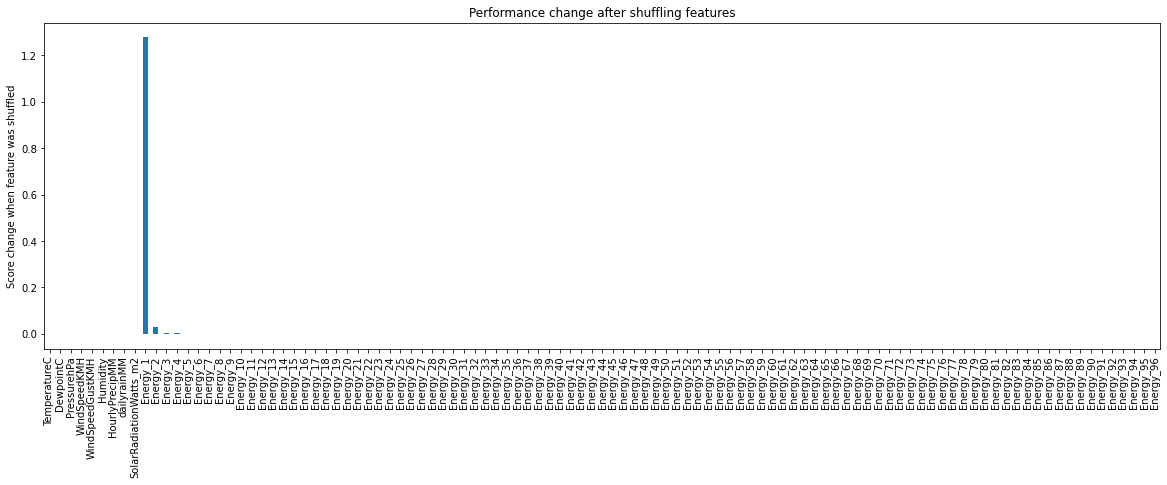

In [34]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.title('Performance change after shuffling features')
plt.ylabel('Score change when feature was shuffled')
plt.show()

In [35]:
sel.features_to_drop_

['TemperatureC',
 'DewpointC',
 'PressurehPa',
 'WindSpeedKMH',
 'WindSpeedGustKMH',
 'Humidity',
 'HourlyPrecipMM',
 'dailyrainMM',
 'SolarRadiationWatts_m2',
 'Energy_3',
 'Energy_4',
 'Energy_5',
 'Energy_6',
 'Energy_7',
 'Energy_8',
 'Energy_9',
 'Energy_10',
 'Energy_11',
 'Energy_12',
 'Energy_13',
 'Energy_14',
 'Energy_15',
 'Energy_16',
 'Energy_17',
 'Energy_18',
 'Energy_19',
 'Energy_20',
 'Energy_21',
 'Energy_22',
 'Energy_23',
 'Energy_24',
 'Energy_25',
 'Energy_26',
 'Energy_27',
 'Energy_28',
 'Energy_29',
 'Energy_30',
 'Energy_31',
 'Energy_32',
 'Energy_33',
 'Energy_34',
 'Energy_35',
 'Energy_36',
 'Energy_37',
 'Energy_38',
 'Energy_39',
 'Energy_40',
 'Energy_41',
 'Energy_42',
 'Energy_43',
 'Energy_44',
 'Energy_45',
 'Energy_46',
 'Energy_47',
 'Energy_48',
 'Energy_49',
 'Energy_50',
 'Energy_51',
 'Energy_52',
 'Energy_53',
 'Energy_54',
 'Energy_55',
 'Energy_56',
 'Energy_57',
 'Energy_58',
 'Energy_59',
 'Energy_60',
 'Energy_61',
 'Energy_62',
 'Energ

In [36]:
X_shuffled = sel.transform(X24)
X_shuffled

,Energy_1,Energy_2
0,2.528,2.917
1,3.054,2.528
2,2.677,3.054
3,3.522,2.677
4,2.729,3.522
...,...,...
11985,3.106,2.932
11986,3.115,3.106
11987,2.596,3.115
11988,2.903,2.596


### Train Shuffled model

In [37]:
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(X_shuffled, y24, test_size=0.2, random_state=42)
model_shuffled, preds_shuffled = build_model(X_train_shuffled, y_train_shuffled, X_test_shuffled)

In [38]:
X_train_shuffled

,Energy_1,Energy_2
3785,3.142,2.902
10502,2.743,3.013
288,2.824,2.396
9979,2.784,2.711
5344,5.452,5.706
...,...,...
11964,4.729,4.654
5191,2.630,2.784
5390,3.177,3.094
860,3.842,3.926


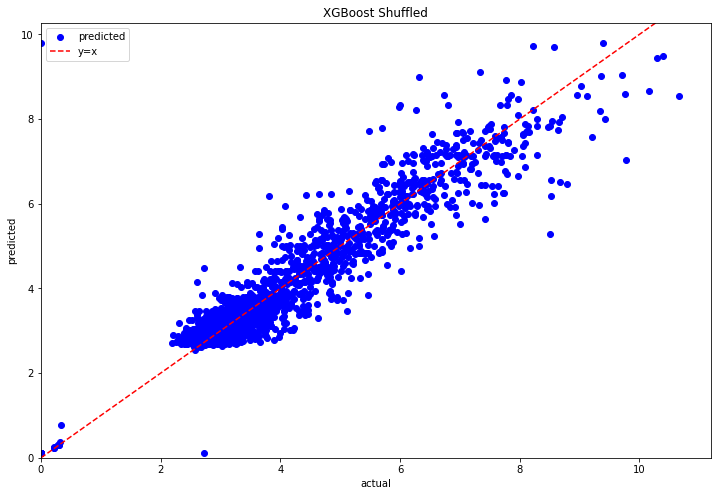

In [39]:
plt.figure(figsize=(12, 8))

plot_results(preds_shuffled, y_test_shuffled, 'XGBoost Shuffled')

In [40]:
performance_metrics(preds_shuffled, y_test_shuffled.values.reshape(-1))

MSE: 0.2427
RMSE: 0.4926
MAE: 0.3128
WMAPE: 8.1791
R2: 0.8900


In [41]:
scores = cv_validate(xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42), X_train_shuffled, y_train_shuffled, 10)

R2 score: 0.91 +- 0.01


In [32]:
features_7 = pd.DataFrame()
for i in range(1, 8):
    features_7[f'Energy_{i*15}'] = df_energy.shift(i * 96)

features_7.dropna(inplace=True)
X_previous_7days = features_7.reset_index(drop=True)
X_previous_7days

,Energy_1,Energy_2,Energy_3,Energy_4,Energy_5,Energy_6,Energy_7
0,2.615,3.321,3.066,2.351,2.851,3.054,2.964
1,2.634,2.873,3.152,2.843,3.102,2.677,2.584
2,3.052,3.407,2.633,2.949,2.546,3.522,3.071
3,2.893,2.673,2.590,2.605,3.016,2.729,2.694
4,2.349,2.390,2.330,3.023,3.031,2.368,2.569
...,...,...,...,...,...,...,...
34459,1.664,1.659,1.648,1.662,1.665,1.627,1.667
34460,1.659,1.666,1.664,1.669,1.659,1.675,1.678
34461,1.664,1.665,1.664,1.681,1.639,1.636,1.641
34462,1.697,1.680,1.662,1.658,1.639,1.632,1.696
